In [496]:
# CARGAMOS LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

import boto3
import s3fs
import fastparquet
import awswrangler as wr
import os

import pyarrow.parquet as pq
import pyarrow as pa

import requests
import json
from io import BytesIO
from pandas.tseries.offsets import BDay

import math

In [498]:
# INICIALIZAMOS UNA SESION EN AWS
session = boto3.Session(
    aws_access_key_id=os.environ['S3_ACCESS_KEY'],
    aws_secret_access_key=os.environ['S3_SECRET_KEY'],
    region_name=os.environ['S3_REGION'])

s3_client = boto3.client('s3')
s3 = boto3.resource('s3')

In [499]:
bucket_name = 'stock-market-historical-data'
processed_folder = 'processed/marketstack/'
file_name = 'ibex_historical_data'
full_path = processed_folder + file_name

In [500]:
def download_s3_parquet_file(s3, bucket, key):
    buffer = BytesIO()
    s3.Object(bucket, key).download_fileobj(buffer)
    return buffer

In [678]:
# CARGAMOS EL DATAFRAME CON TODOS LOS DATOS DE CIERRE DE TODOS LOS ACTIVOS DESDE 02/01/1991
processed_folder = 'processed/marketstack/'
file_name = 'ibex_historical_data'
full_path = processed_folder + file_name
marketstack_historical_data = pd.DataFrame(pq.read_table(download_s3_parquet_file(s3, bucket_name,full_path)).to_pandas())

In [679]:
# CARGAMOS EL DATAFRAME CON TODOS LOS DATOS DE CIERRE DE TODOS LOS ACTIVOS DESDE 02/01/1991
processed_folder = 'processed/yfinance/'
file_name = 'ibex_historical_data'
full_path = processed_folder + file_name
yfinance_historical_data = pd.DataFrame(pq.read_table(download_s3_parquet_file(s3, bucket_name,full_path)).to_pandas())

In [680]:
# CARGAMOS EL DATAFRAME CON TODOS LOS DATOS DE CIERRE DE TODOS LOS ACTIVOS DESDE 02/01/1991
processed_folder = 'processed/bme-data/'
file_name = 'ibex_historical_data'
full_path = processed_folder + file_name
bme_historical_data = pd.DataFrame(pq.read_table(download_s3_parquet_file(s3, bucket_name,full_path)).to_pandas())
bme_historical_data.drop(['NHH_1'], axis=1, inplace=True)

In [681]:
marketstack_historical_data.shape, yfinance_historical_data.shape, bme_historical_data.shape

((7604, 170), (6097, 170), (5159, 88))

In [682]:
marketstack_historical_data.isnull().sum().sum(), yfinance_historical_data.isnull().sum().sum(), bme_historical_data.isnull().sum().sum()

(1125476, 883106, 277577)

In [699]:
sub = 'SAN'

for ticker in bme_historical_data.columns:
    if sub in ticker:
        print(ticker)

SAN


In [684]:
bme_historical_data.columns

Index(['SAN', 'BTO_1', 'BKIA_0', 'BKIA', 'NTGY', 'TRE', 'ACX_0', 'ACX', 'FER',
       'ACS', 'ELE_0', 'ELE', 'SAB', 'CRI', 'OHL', 'IBR', 'EBRO_0', 'EBRO_1',
       'AMS', 'AENA', 'ITX', 'MTS', 'IAG', 'VIS_0', 'VIS', 'IBLA', 'BBVA',
       'MAP', 'BME', 'CIE', 'MAS', 'IBE', 'ABG', 'ENG', 'SCYR_1', 'REP', 'ABE',
       'ABG.P_0', 'ABG.P_1', 'ANA_0', 'ANA', 'EVA', 'GRF', 'CLNX', 'MRL',
       'BKT', 'POP', 'ENC', 'IDR', 'SGRE_0', 'SGRE', 'MEL', 'TL5', 'REE',
       'COL', 'JAZ', 'TEF', 'FCC', 'CABK', 'DIA', 'ALM', 'REE_0', 'CIN', 'LOR',
       'UNF', 'ZEL', 'NHH_0', 'MAP_0', 'ALT', 'BTO_0', 'FAD', 'DRC', 'PRS_0',
       'PRS_1', 'SCYR_0', 'TEM', 'CAR', 'AGS', 'COL_0', 'A3TV', 'SGC', 'ANE',
       'FDR', 'PHM', 'ROVI', 'SCYR', 'SLR', 'UNI'],
      dtype='object')

In [700]:
bme_historical_data = bme_historical_data.rename(columns={
    'ACX_1':'ACX_2',
    'ACX': 'ACX_1',
    'BKIA': 'BKIA_1',
    'BKIA_0': 'BKIA',
    'ABG.P_0':'ABG.P',
    'VIS':'VIS_3',
    'VIS_0':'VIS_2',
    'EBRO_0': 'EBRO',
    'BTO_1':'BTO_2',
    'BTO_0':'BTO_1',
    'SGRE_0': 'SGRE',
    'ANA': 'ANA_1',
    'ANA_0': 'ANA',
    'REE_0': 'REE',
    'COL_0': 'COL',
    'COL': 'COL_1',
    'MAP':'MAP_2',
    'MAP_0':'MAP_1',
    'PRS_0':'PRS',
    'ELE':'ELE_1',
    'ELE_0':'ELE',
    'ENC':'ENC_1',
    'AMS':'AMS_1',
    'SCYR':'SCYR_2',
    'SCYR_0':'SCYR',
    'OHL':'OHLA',
    'SAN':'SAN_1'
    })

In [701]:
ibex_historical_data = pd.DataFrame(columns=marketstack_historical_data.columns)

In [702]:
for c in ibex_historical_data.columns:
    try:
        ibex_historical_data[c] = marketstack_historical_data[c].fillna(yfinance_historical_data[c])
        ibex_historical_data[c] = ibex_historical_data[c].fillna(bme_historical_data[c])
        print('ok ' + c)
    except:
        print('failed ' + c)

ok A3TV
ok ABE
ok ABG.P
ok ABG.P_1
ok ABG
failed ACE
failed ACR
ok ACS
failed ACX
failed ACX_1
ok ACX_2
ok AENA
failed AGR
ok AGS
failed AGS_1
failed AGS_2
failed AGS_3
failed ALB
failed ALB_1
failed ALB_2
failed ALB_3
ok ALM
ok ALT
failed AMP
failed AMS
ok AMS_1
failed ANA
failed ANA_1
failed ANA_2
ok ANE
failed ARA
failed ARG
failed ASL
failed AUM
failed AZC
failed AZC_1
failed BBV
ok BBVA
failed BCH
failed BKIA
failed BKIA_1
ok BKT
ok BME
failed BTO
failed BTO_1
failed BTO_2
ok CABK
failed CAN
ok CAR
failed CEN
failed CEP
failed CEP_1
ok CIE
ok CIN
ok CLNX
failed COL
failed COL_1
failed CRF
ok CRI
failed CRI_1
failed CRI_2
failed CTE
failed CTF
failed CTG
failed CUB
ok DIA
ok DRC
failed EBA
ok EBRO
ok EBRO_1
failed ECR
failed ELE
failed ELE_1
failed ENC
ok ENC_1
ok ENG
ok EVA
failed EXT
ok FAD
ok FCC
ok FDR
failed FEC
ok FER
failed FOC
failed GAM
failed GAM_1
failed GAS
failed GES
failed GES_1
failed GPP
ok GRF
failed HHU
failed HHU_1
failed HID
failed HIS
ok IAG
ok IBE
ok IBLA
ok I

In [703]:
ibex_historical_data['BTO_1'] = yfinance_historical_data['BTO_1']
ibex_historical_data['BTO_2'] = yfinance_historical_data['BTO_2']
ibex_historical_data['ABE'] = yfinance_historical_data['ABE']

In [704]:
ibex_historical_data['benchmark'] = yf.download('^IBEX')['Adj Close']
ibex_historical_data.index = pd.to_datetime(ibex_historical_data.index)

[*********************100%***********************]  1 of 1 completed


C:\Users\aleja\AppData\Local\Temp\ipykernel_17272\3243579471.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ibex_historical_data['benchmark'] = yf.download('^IBEX')['Adj Close']


In [716]:
ibex_historical_data_cleaned.to_csv('ibex_historical_data.csv',index=True)

In [706]:
failed_loads = ibex_historical_data.columns[ibex_historical_data.isnull().values.all(axis=0)]
print('Missing tickers are {}'.format(len(failed_loads)))
print(np.array(failed_loads))

Missing tickers are 65
['ACE' 'ACR' 'ACX' 'AGR' 'AGS_1' 'AGS_2' 'AGS_3' 'ALB' 'ALB_1' 'AMS' 'ARA'
 'ARG' 'ASL' 'AUM' 'AZC' 'AZC_1' 'BBV' 'BCH' 'BTO' 'CAN' 'CEN' 'CEP'
 'CEP_1' 'CRF' 'CRI_1' 'CRI_2' 'CTE' 'CTF' 'CTG' 'CUB' 'EBA' 'ECR' 'EXT'
 'FEC' 'FOC' 'GAS' 'GES' 'GES_1' 'GPP' 'HHU' 'HHU_1' 'HID' 'HIS' 'MVC'
 'MVC_1' 'PMD' 'PRY' 'PUL' 'RAD' 'SAR' 'SCH' 'SEV' 'SOL' 'SYV' 'SYV_1'
 'TAB' 'TPI' 'TPZ' 'TRR' 'TRR_1' 'URA' 'URB' 'VAL' 'VAL_1' 'VDR']


In [707]:
for c in ibex_historical_data.columns:
    if ibex_historical_data[c].isnull().sum() != ibex_historical_data[c].shape[0]:
        first_valid = ibex_historical_data.loc[ibex_historical_data[c].notnull()][c].index[0]
        last_valid = ibex_historical_data.loc[ibex_historical_data[c].notnull()][c].index[-1]
        data = ibex_historical_data[c].loc[first_valid:last_valid]
        ibex_historical_data[c] = data.fillna(method='ffill')
        print(c, ibex_historical_data[c].loc[first_valid:last_valid].isnull().sum())
    else:
        print(c, 'null')
    

A3TV 0
ABE 0
ABG.P 0
ABG.P_1 0
ABG 0
ACE null
ACR null
ACS 0
ACX null
ACX_1 0
ACX_2 0
AENA 0
AGR null
AGS 0
AGS_1 null
AGS_2 null
AGS_3 null
ALB null
ALB_1 null
ALB_2 0
ALB_3 0
ALM 0
ALT 0
AMP 0
AMS null
AMS_1 0
ANA 0
ANA_1 0
ANA_2 0
ANE 0
ARA null
ARG null
ASL null
AUM null
AZC null
AZC_1 null
BBV null
BBVA 0
BCH null
BKIA 0
BKIA_1 0
BKT 0
BME 0
BTO null
BTO_1 0
BTO_2 0
CABK 0
CAN null
CAR 0
CEN null
CEP null
CEP_1 null
CIE 0
CIN 0
CLNX 0
COL 0
COL_1 0
CRF null
CRI 0
CRI_1 null
CRI_2 null
CTE null
CTF null
CTG null
CUB null
DIA 0
DRC 0
EBA null
EBRO 0
EBRO_1 0
ECR null
ELE 0
ELE_1 0
ENC 0
ENC_1 0
ENG 0
EVA 0
EXT null
FAD 0
FCC 0
FDR 0
FEC null
FER 0
FOC null
GAM 0
GAM_1 0
GAS null
GES null
GES_1 null
GPP null
GRF 0
HHU null
HHU_1 null
HID null
HIS null
IAG 0
IBE 0
IBLA 0
IBR 0
IDR 0
ITX 0
JAZ 0
LOG 0
LOR 0
MAP 0
MAP_1 0
MAP_2 0
MAS 0
MEL 0
MRL 0
MTS 0
MVC null
MVC_1 null
NHH 0
NHH_1 0
NHH_2 0
NTGY 0
OHLA 0
PHM 0
PMD null
POP 0
PRS 0
PRS_1 0
PRY null
PUL null
RAD null
RED 0
REE 0
REE_1

In [708]:
ibex_historical_data_cleaned = ibex_historical_data.dropna(how='all',axis=1)

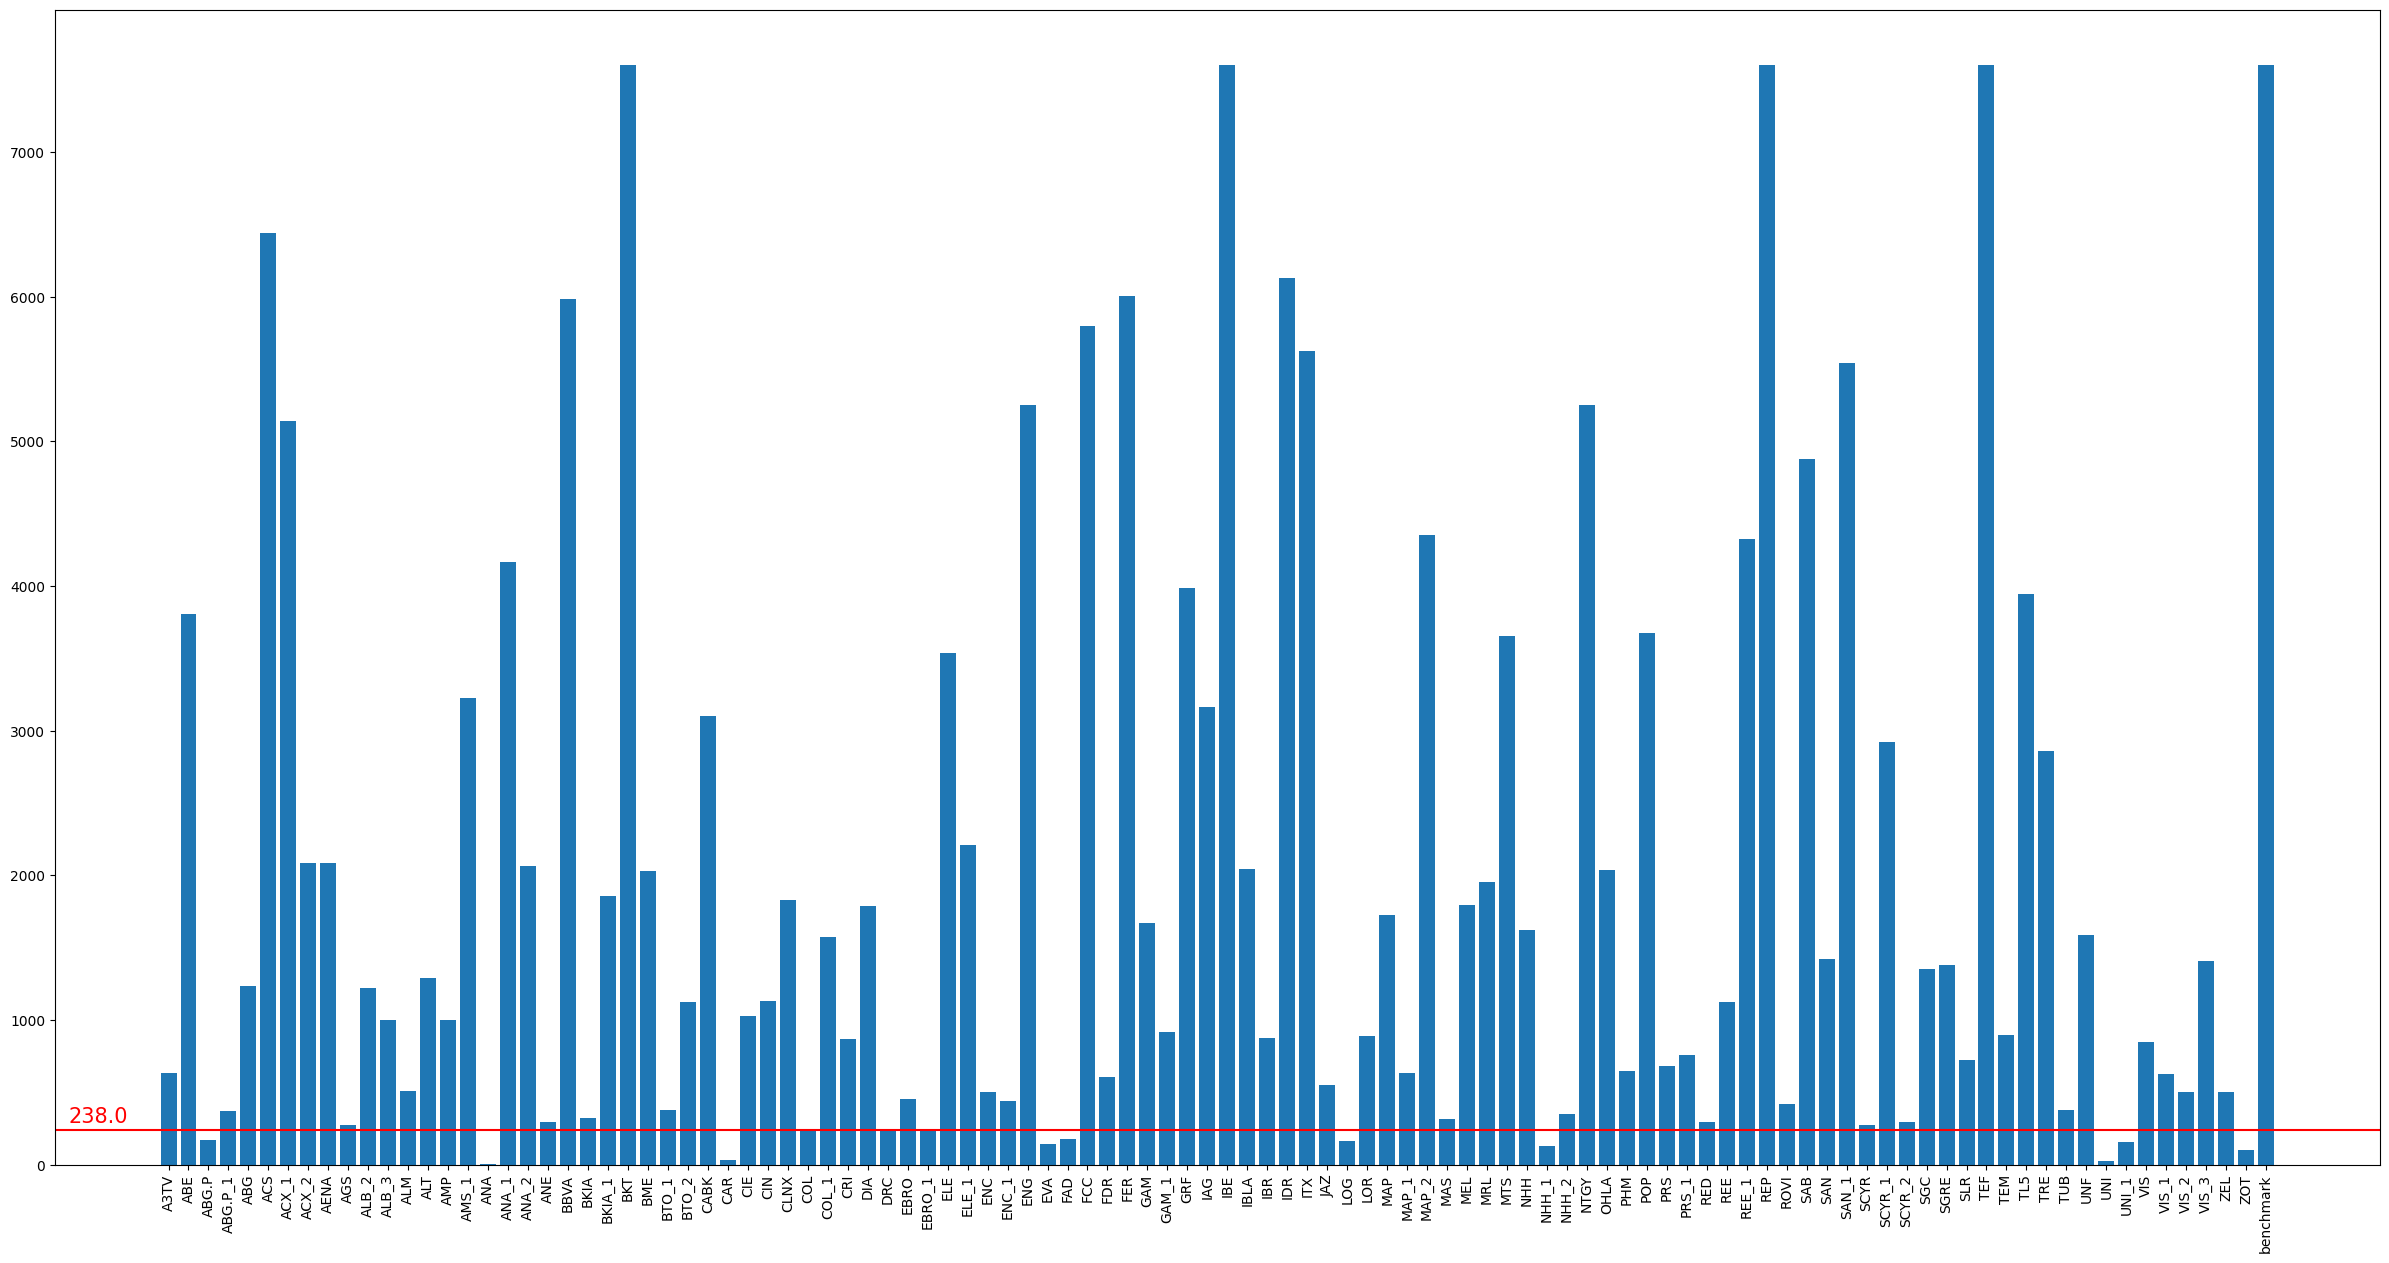

In [709]:
q = 0.1
plt.subplots(figsize=(30,15))
plt.bar(ibex_historical_data_cleaned.columns,ibex_historical_data_cleaned.notnull().sum())
plt.axhline(xmin=0,xmax=len(ibex_historical_data_cleaned.columns),y=ibex_historical_data_cleaned.notnull().sum().quantile(q),c='red')
plt.annotate(ibex_historical_data_cleaned.notnull().sum().quantile(q),xy=(-5,ibex_historical_data_cleaned.notnull().sum().quantile(q)+50),fontsize=15,c='red')
plt.xticks(rotation = 90);

In [710]:
few_registers = ibex_historical_data_cleaned.loc[:,ibex_historical_data_cleaned.notnull().sum() < ibex_historical_data_cleaned.notnull().sum().quantile(q)].columns
ibex_historical_data_cleaned = ibex_historical_data_cleaned.drop(few_registers,axis=1)

In [717]:
returns = np.log(ibex_historical_data_cleaned).diff()[1:]
returns.to_csv('ibex_historical_returns.csv',index=True)

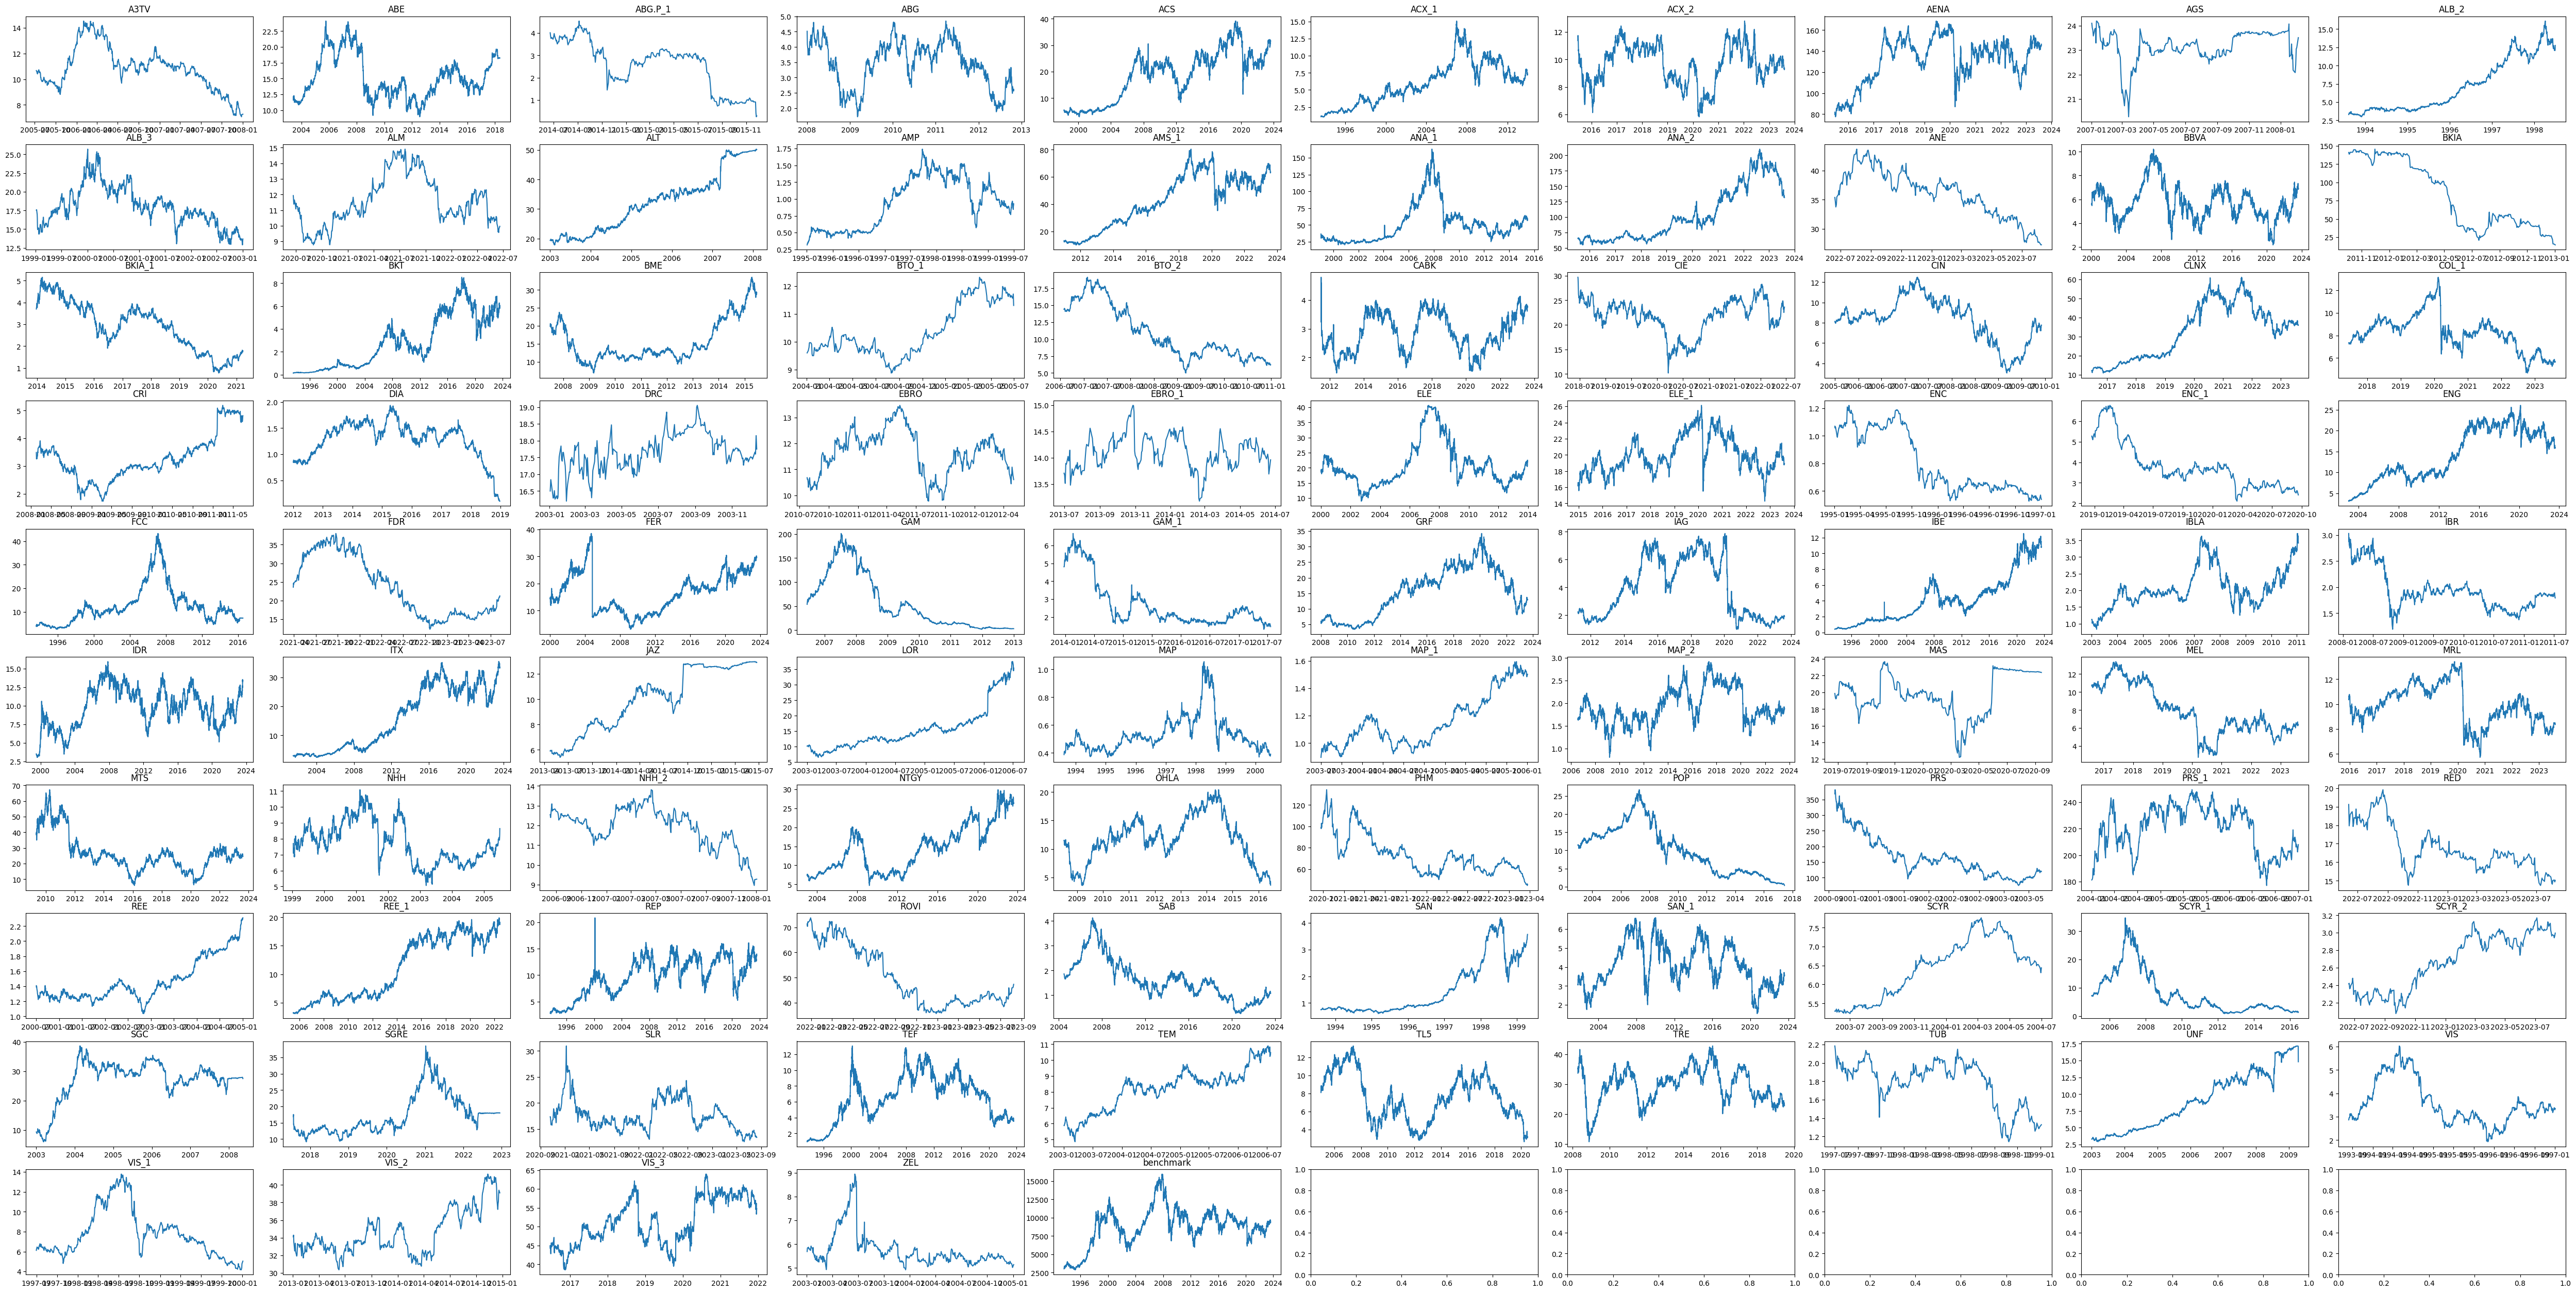

In [712]:
# GRAFICAMOS LOS RETORNOS DE TODOS LOS ACTIVOS
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(50, 25))
fig.tight_layout()
axs = axs.ravel()

for i in range(len(ibex_historical_data_cleaned.columns)):

    axs[i].plot(ibex_historical_data_cleaned[ibex_historical_data_cleaned.columns[i]].dropna())
    axs[i].set_title(ibex_historical_data_cleaned.columns[i])


In [719]:
# LEEMOS EL FICHERO CON LA COMPOSICIÓN HISTORICA
ibex_constituents = pd.read_excel('data_processing/Historical Composition IBEX35.xlsx')
ibex_constituents.head()

# ibex_constituents['Exclusion'] -= BDay(1)

# ibex_constituents['Inclusion'] = ibex_constituents['Inclusion'].dt.date
# ibex_constituents['Exclusion'] = ibex_constituents['Exclusion'].dt.date

# OBTENEMOS EL DIA ACTUAL
today = datetime.date.today().strftime('%Y-%m-%d')

# COMPLETAMOS LOS DATOS NULOS EN EL FICHERO DE COMPOSICIÓN HISTORICA CON LA FECHA ACTUAL
ibex_constituents.fillna(today,inplace=True)

# DEFINIMOS UNA VARIABLE PARA TODOS LOS ACTIVOS
activos = ibex_constituents.Activo
ibex_constituents['Ticker'] = activos.apply(lambda x: x.split('_')[0])

unique_activos = list(set(activos))

In [816]:
ibex_constituents['Active Days'] = ibex_constituents['Exclusion'] - ibex_constituents['Inclusion']
ibex_constituents[['Activo','Active Days']]

(    Activo Active Days
 0      ACE   4534 days
 1      ACX    180 days
 2      ALB    180 days
 3      ASL   1097 days
 4      BBV   3316 days
 ..     ...         ...
 163   ROVI    599 days
 164    RED    424 days
 165    ANE    417 days
 166    LOG    235 days
 167  UNI_1    227 days
 
 [168 rows x 2 columns],)

In [824]:
ibex_constituents['Inclusion'][i],ibex_constituents['Active Days'][i],ibex_constituents['Activo'][i]

(Timestamp('2022-06-20 00:00:00'), Timedelta('417 days 00:00:00'), 'ANE')

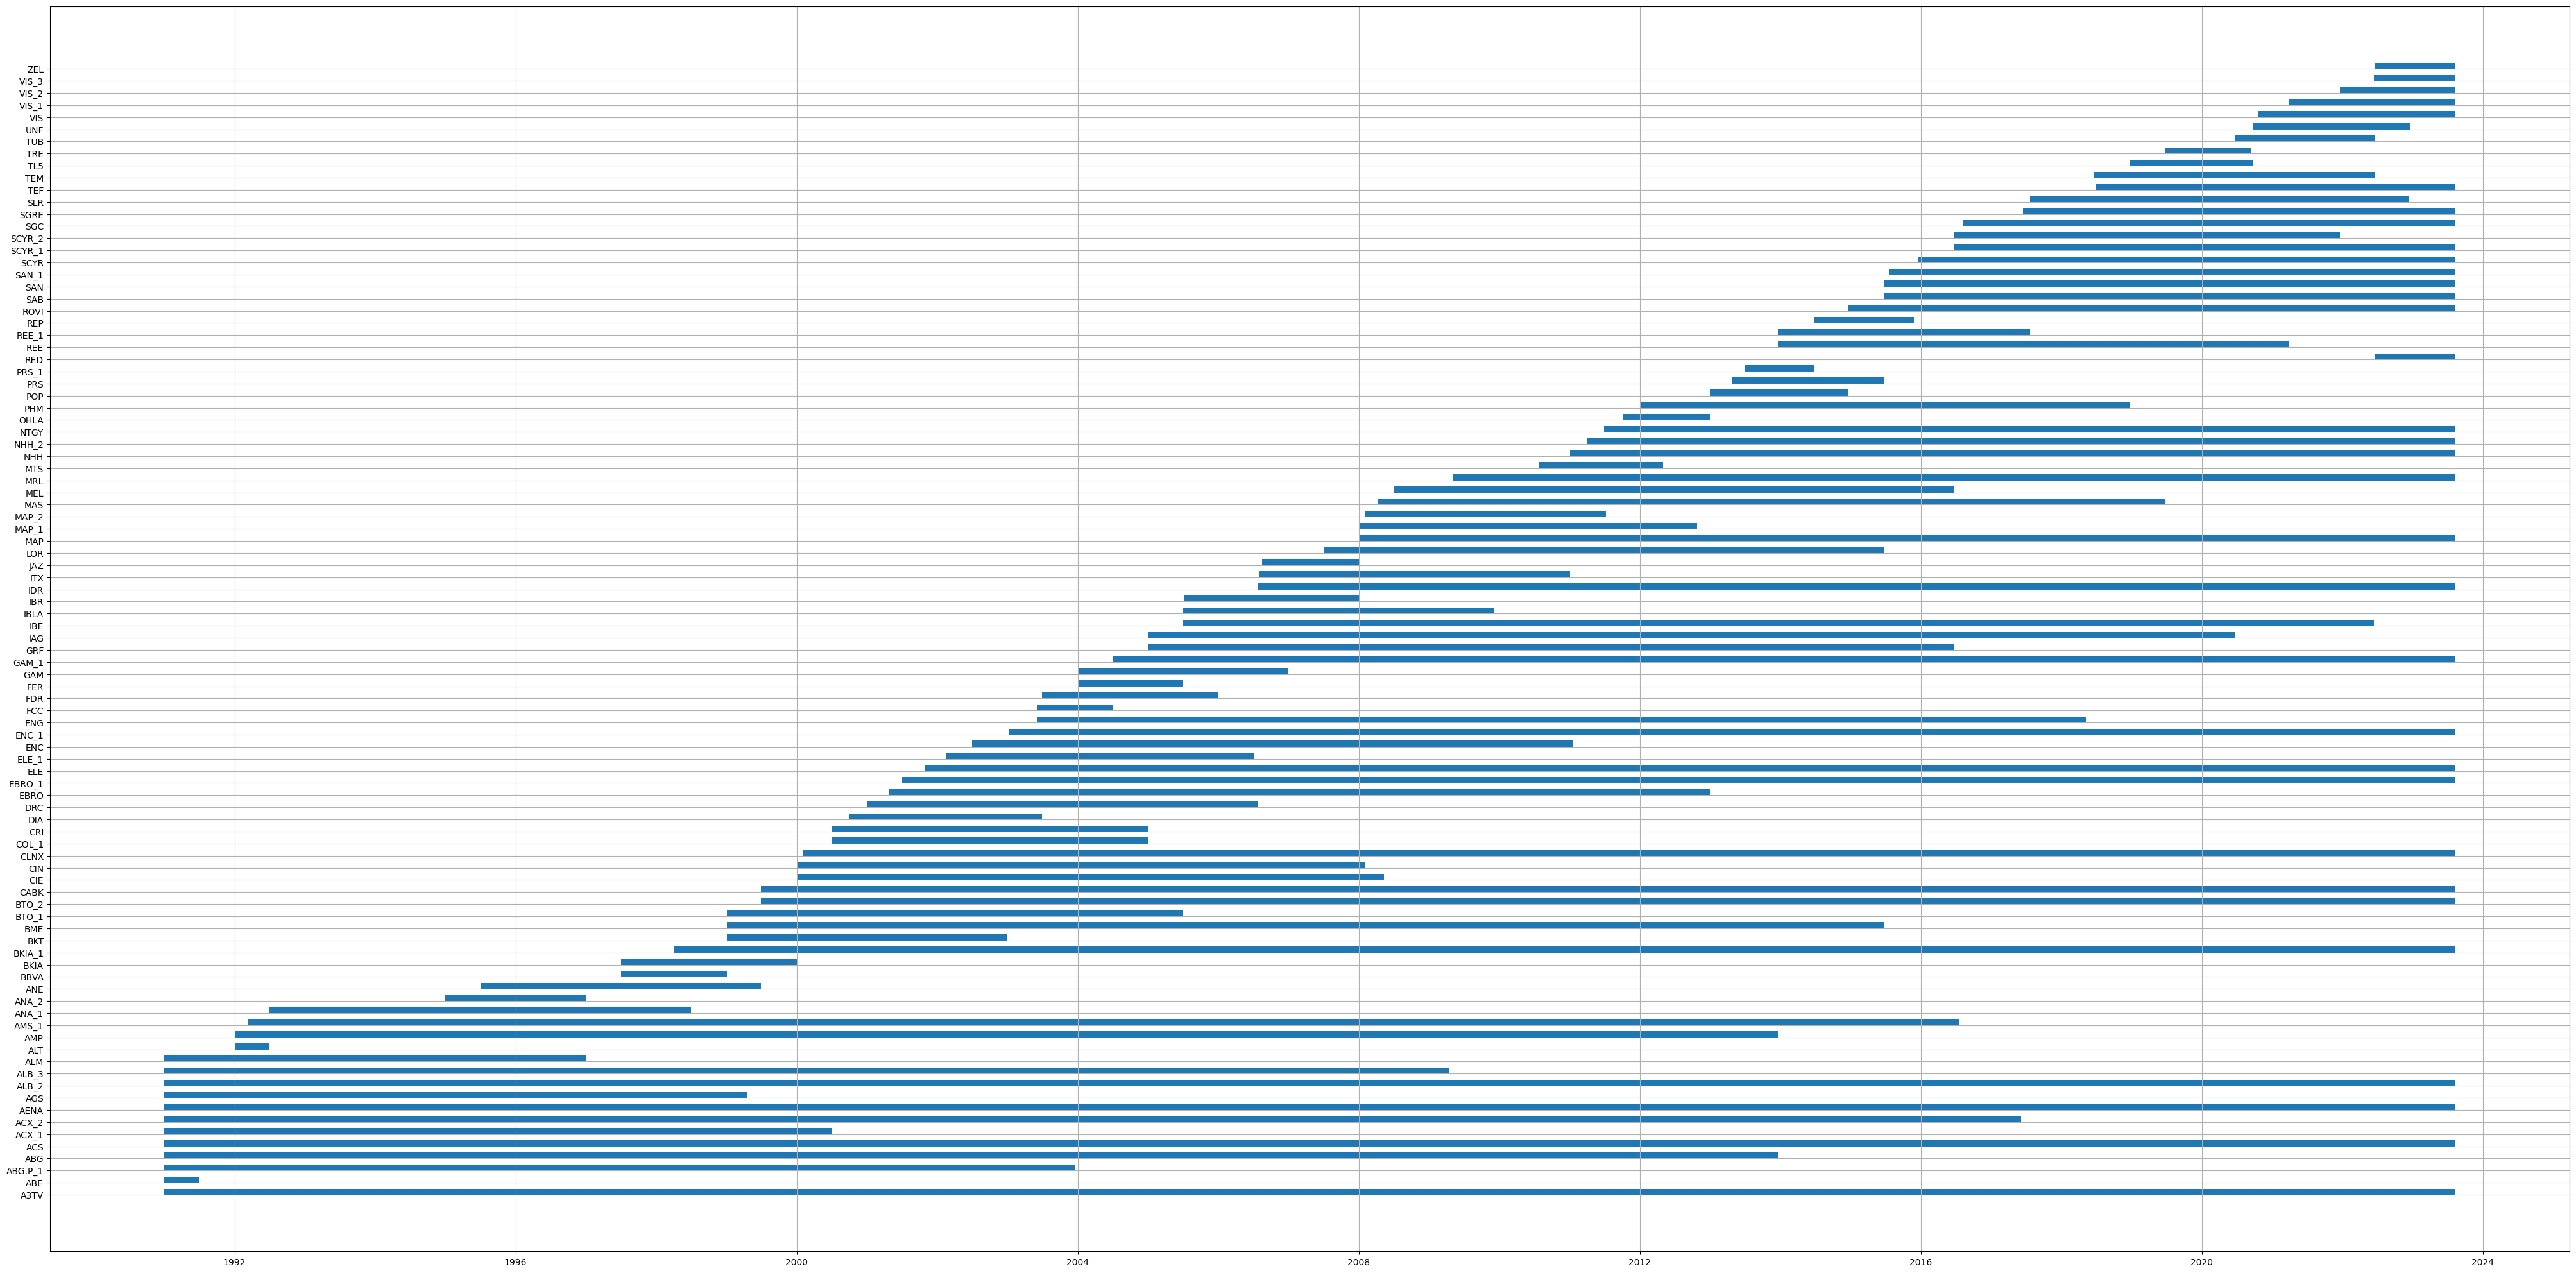

In [833]:
fig, axs = plt.subplots(figsize=(40, 20))
axs.grid(True)
fig.tight_layout()

indexes = ibex_constituents.loc[ibex_constituents['Activo'].isin(ibex_historical_data_cleaned.columns)].index
j = 0
for i in indexes:

    axs.broken_barh([(ibex_constituents['Inclusion'][i], ibex_constituents['Active Days'][i])], (j*40, 20), label=ibex_constituents.Activo[i])
    j += 1
    
axs.set_yticks(np.array(range(len(ibex_historical_data_cleaned.columns[:-1])))*40)
axs.set_yticklabels(ibex_historical_data_cleaned.columns[:-1]);

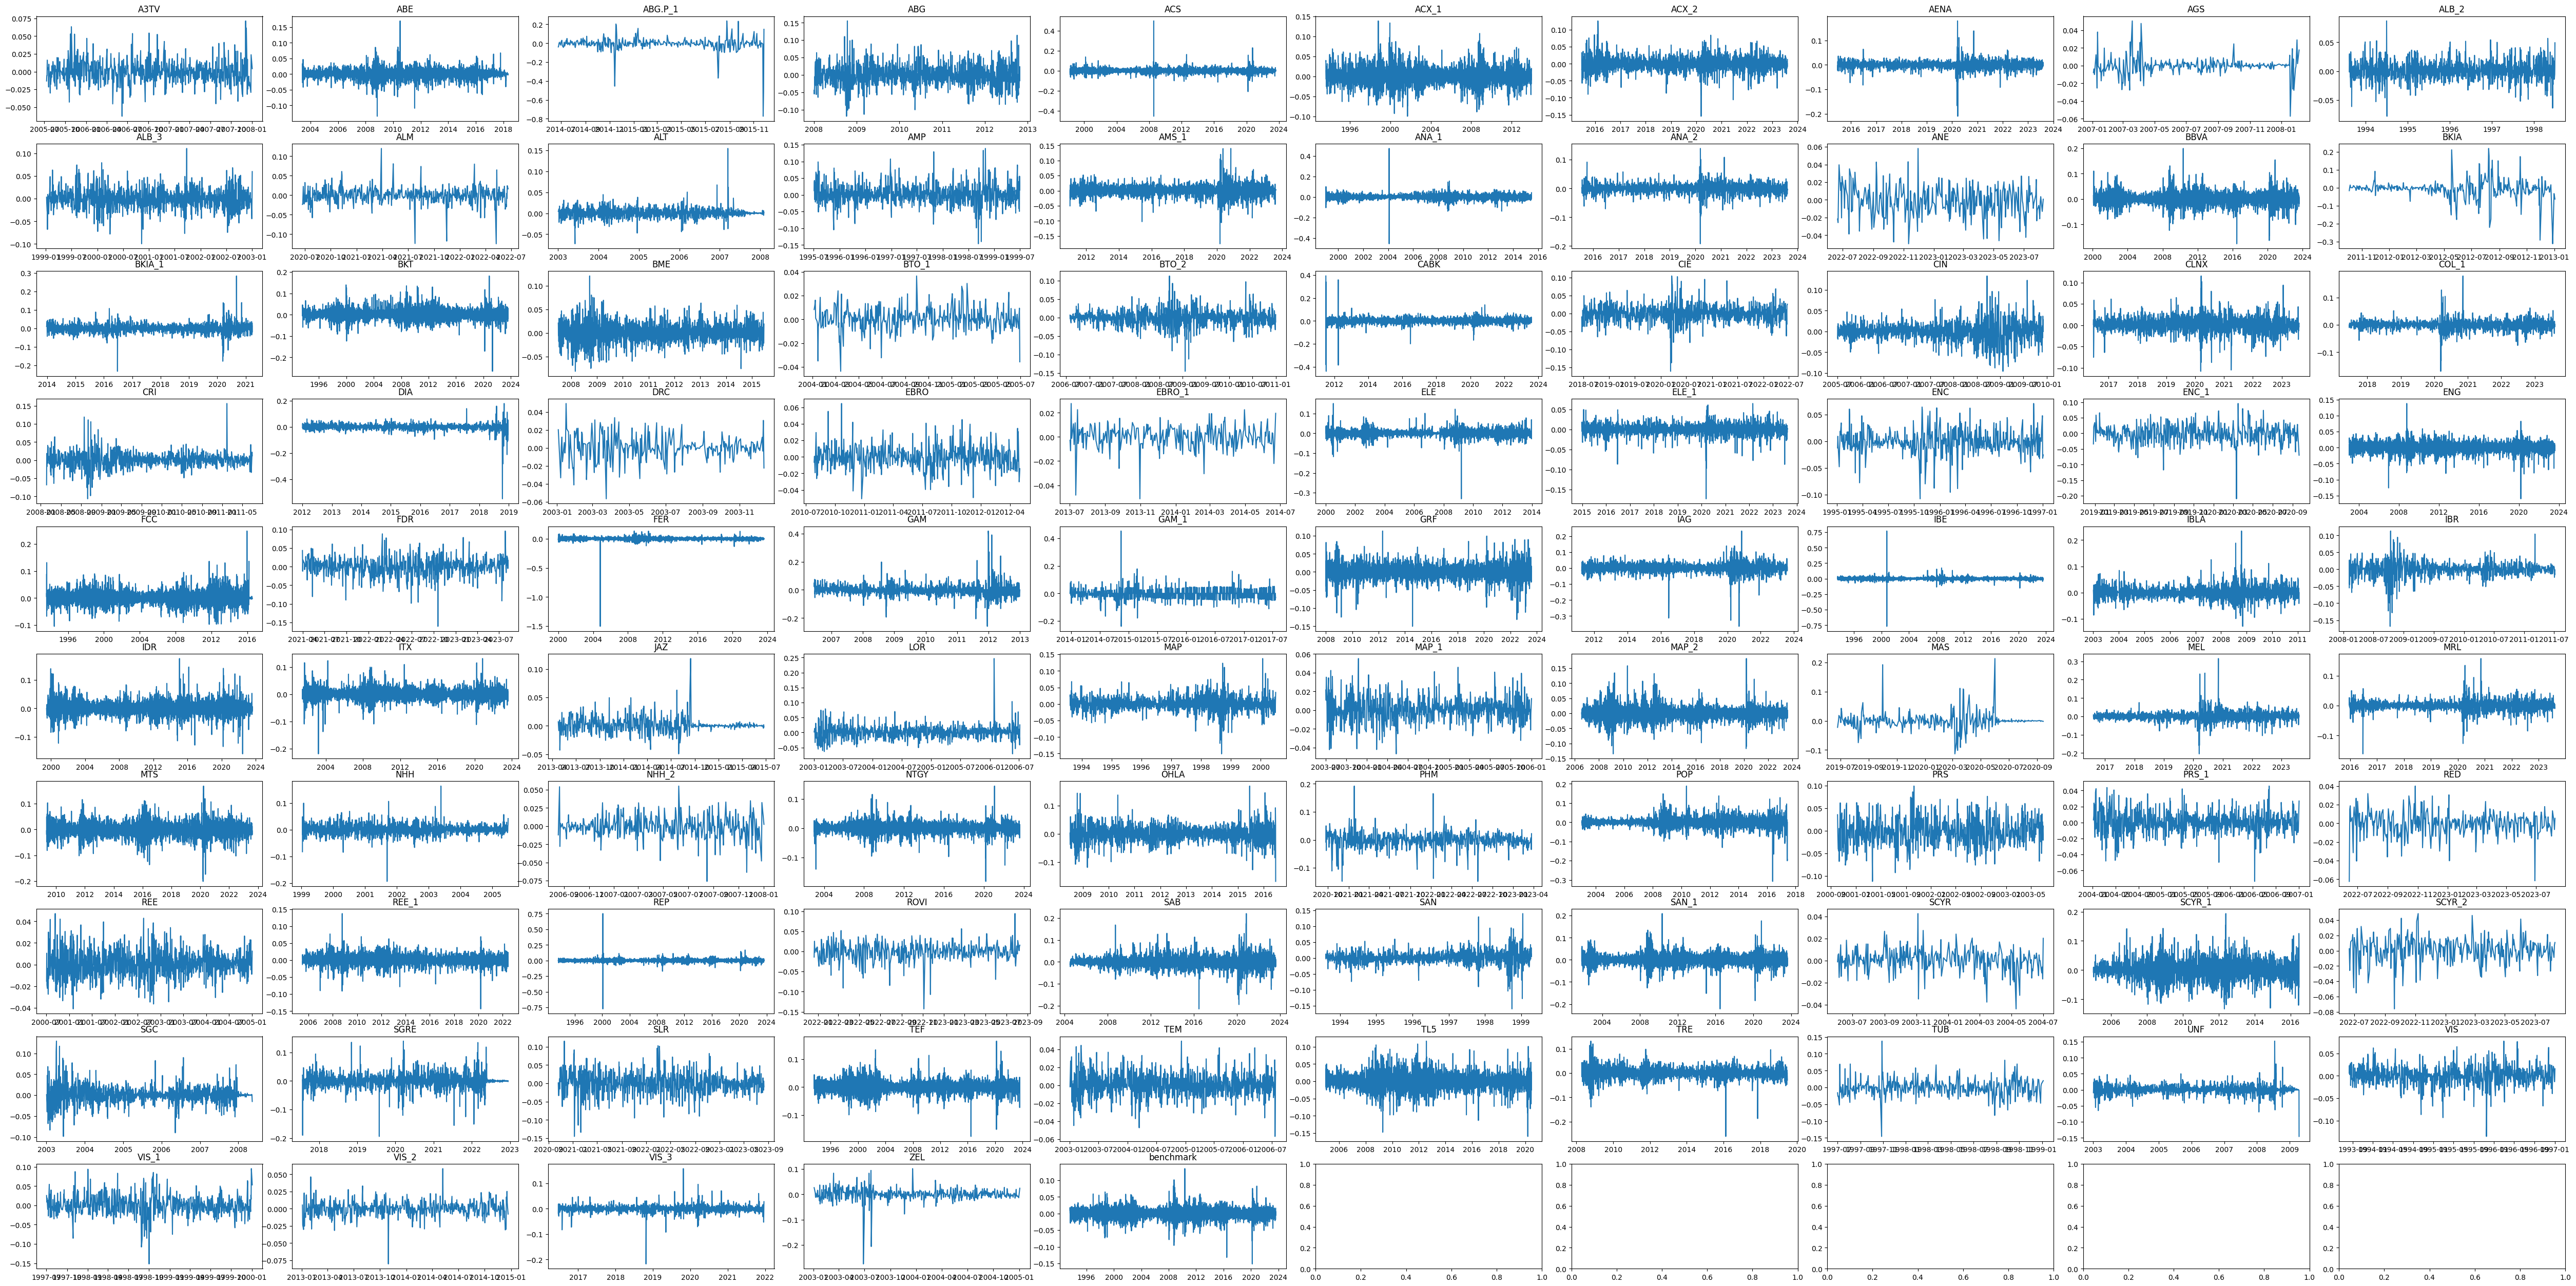

In [ ]:
# GRAFICAMOS LOS RETORNOS DE TODOS LOS ACTIVOS
fig, axs = plt.subplots(nrows=10,ncols=10, figsize=(50, 25))
fig.tight_layout()
axs = axs.ravel()

for i in range(len(returns.columns)):
    axs[i].plot(returns[returns.columns[i]].dropna())
    axs[i].set_title(returns.columns[i])

In [722]:
# GRAFICAMOS LOS RETORNOS DE TODOS LOS ACTIVOS
fig, axs = plt.subplots(nrows=10,ncols=10, figsize=(50, 25))
fig.tight_layout()
axs = axs.ravel()

for i in range(len(returns.columns)):
    axs[i].plot(returns[returns.columns[i]].dropna())
    axs[i].set_title(returns.columns[i])

Error in callback <function flush_figures at 0x000001B59618D990> (for post_execute):


KeyboardInterrupt: 

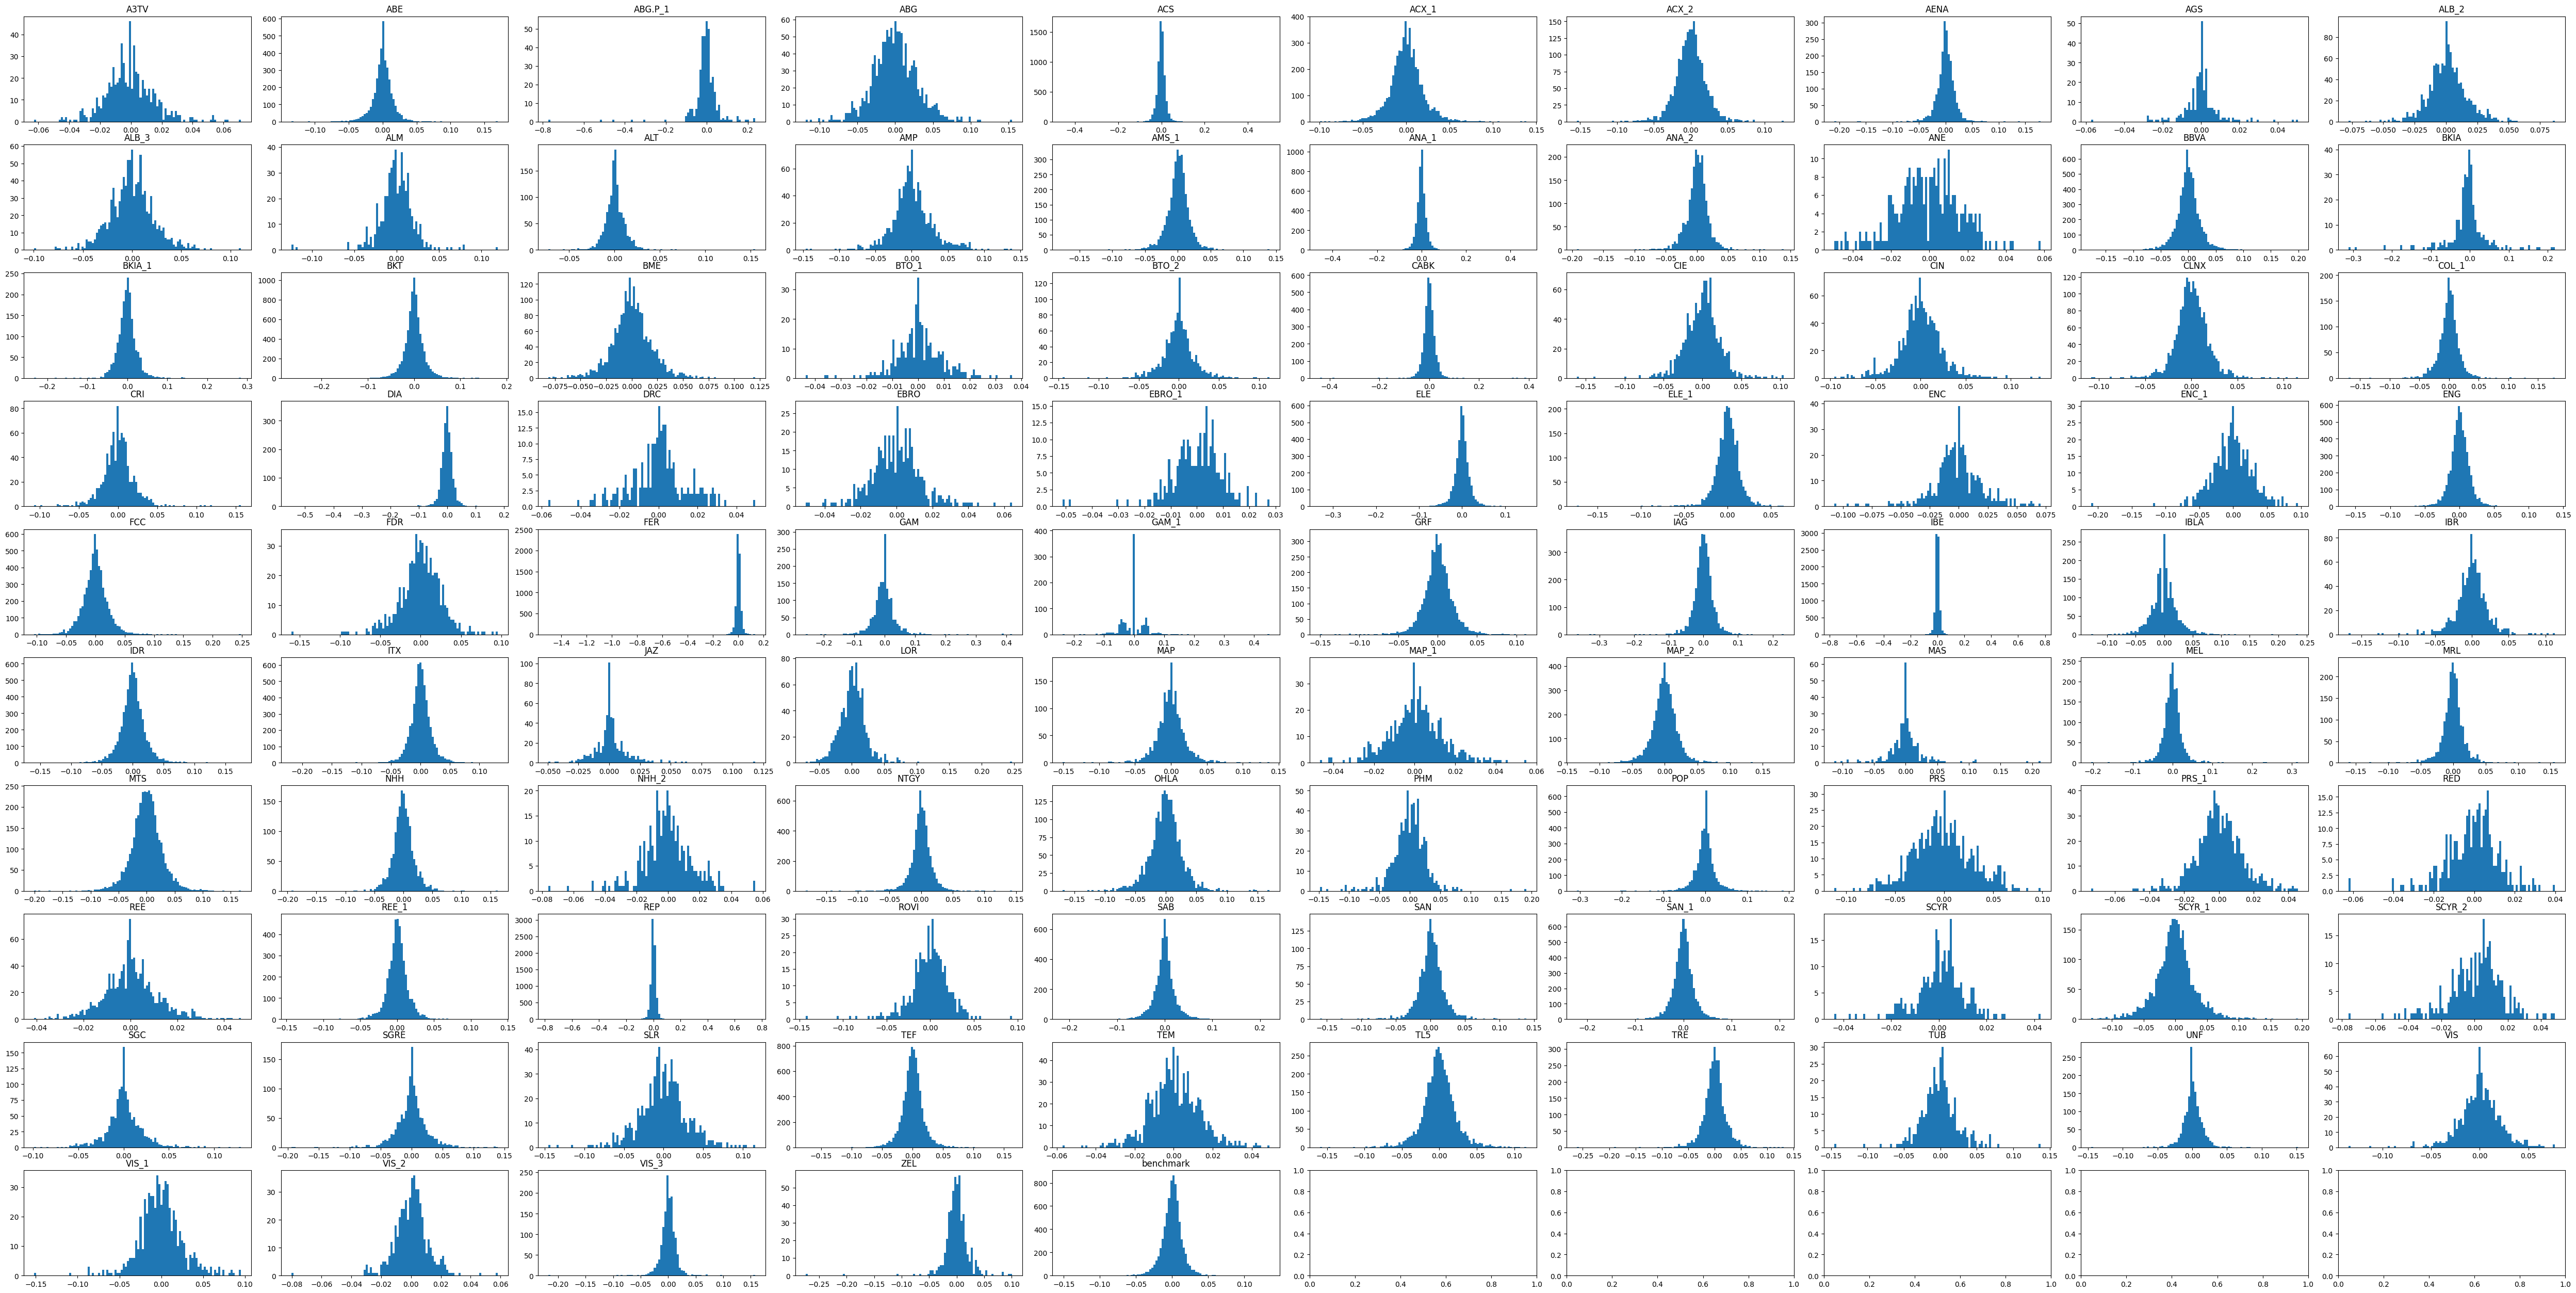

In [713]:
# GRAFICAMOS LOS RETORNOS DE TODOS LOS ACTIVOS
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(50, 25))
fig.tight_layout()
axs = axs.ravel()

for i in range(len(returns.columns)):

    axs[i].hist(returns[returns.columns[i]].dropna(),bins=100)
    axs[i].set_title(returns.columns[i])

In [714]:
returns.cov()

A3TV       ABE   ABG.P_1       ABG       ACS     ACX_1  \
A3TV       0.000258  0.000068       NaN       NaN  0.000076  0.000080   
ABE        0.000068  0.000226  0.000117  0.000343  0.000149  0.000141   
ABG.P_1         NaN  0.000117  0.005573       NaN  0.000326       NaN   
ABG             NaN  0.000343       NaN  0.000878  0.000384  0.000380   
ACS        0.000076  0.000149  0.000326  0.000384  0.000442  0.000155   
...             ...       ...       ...       ...       ...       ...   
VIS_1           NaN       NaN       NaN       NaN  0.000261  0.000225   
VIS_2           NaN  0.000050  0.000139       NaN  0.000052  0.000019   
VIS_3           NaN  0.000026       NaN       NaN  0.000055       NaN   
ZEL             NaN  0.000042       NaN       NaN  0.000063  0.000066   
benchmark  0.000070  0.000147  0.000166  0.000408  0.000182  0.000151   

              ACX_2      AENA       AGS     ALB_2  ...       TL5       TRE  \
A3TV            NaN       NaN  0.000028       NaN  ...  0.000113       NaN   
ABE        0.000073  0.000069  0.000037       NaN  ...  0.000156  0.000160   
ABG.P_1    0.000457 -0.000154       NaN       NaN  ...  0.000194  0.000212   
ABG             NaN       NaN  0.000015       NaN  ...  0.000458  0.000467   
ACS        0.000205  0.000187  0.000051  0.000261  ...  0.000212  0.000180   
...             ...       ...       ...       ...  ...       ...       ...   
VIS_1           NaN       NaN       NaN  0.000126  ...       NaN       NaN   
VIS_2           NaN       NaN       NaN       NaN  ...  0.000060  0.000041   
VIS_3      0.000054  0.000053       NaN       NaN  ...  0.000073  0.000037   
ZEL             NaN       NaN       NaN       NaN  ...       NaN       NaN   
benchmark  0.000161  0.000148  0.000048  0.000083  ...  0.000200  0.000192   

                TUB       UNF       VIS     VIS_1     VIS_2     VIS_3  \
A3TV            NaN  0.000049       NaN       NaN       NaN       NaN   
ABE             NaN  0.000079       NaN       NaN  0.000050  0.000026   
ABG.P_1         NaN       NaN       NaN       NaN  0.000139       NaN   
ABG             NaN  0.000192       NaN       NaN       NaN       NaN   
ACS        0.000351  0.000069       NaN  0.000261  0.000052  0.000055   
...             ...       ...       ...       ...       ...       ...   
VIS_1      0.000384       NaN       NaN  0.000706       NaN       NaN   
VIS_2           NaN       NaN       NaN       NaN  0.000130       NaN   
VIS_3           NaN       NaN       NaN       NaN       NaN  0.000232   
ZEL             NaN  0.000066       NaN       NaN       NaN       NaN   
benchmark  0.000315  0.000090  0.000089  0.000243  0.000054  0.000055   

                ZEL  benchmark  
A3TV            NaN   0.000070  
ABE        0.000042   0.000147  
ABG.P_1         NaN   0.000166  
ABG             NaN   0.000408  
ACS        0.000063   0.000182  
...             ...        ...  
VIS_1           NaN   0.000243  
VIS_2           NaN   0.000054  
VIS_3           NaN   0.000055  
ZEL        0.000617   0.000094  
benchmark  0.000094   0.000200  

[95 rows x 95 columns]

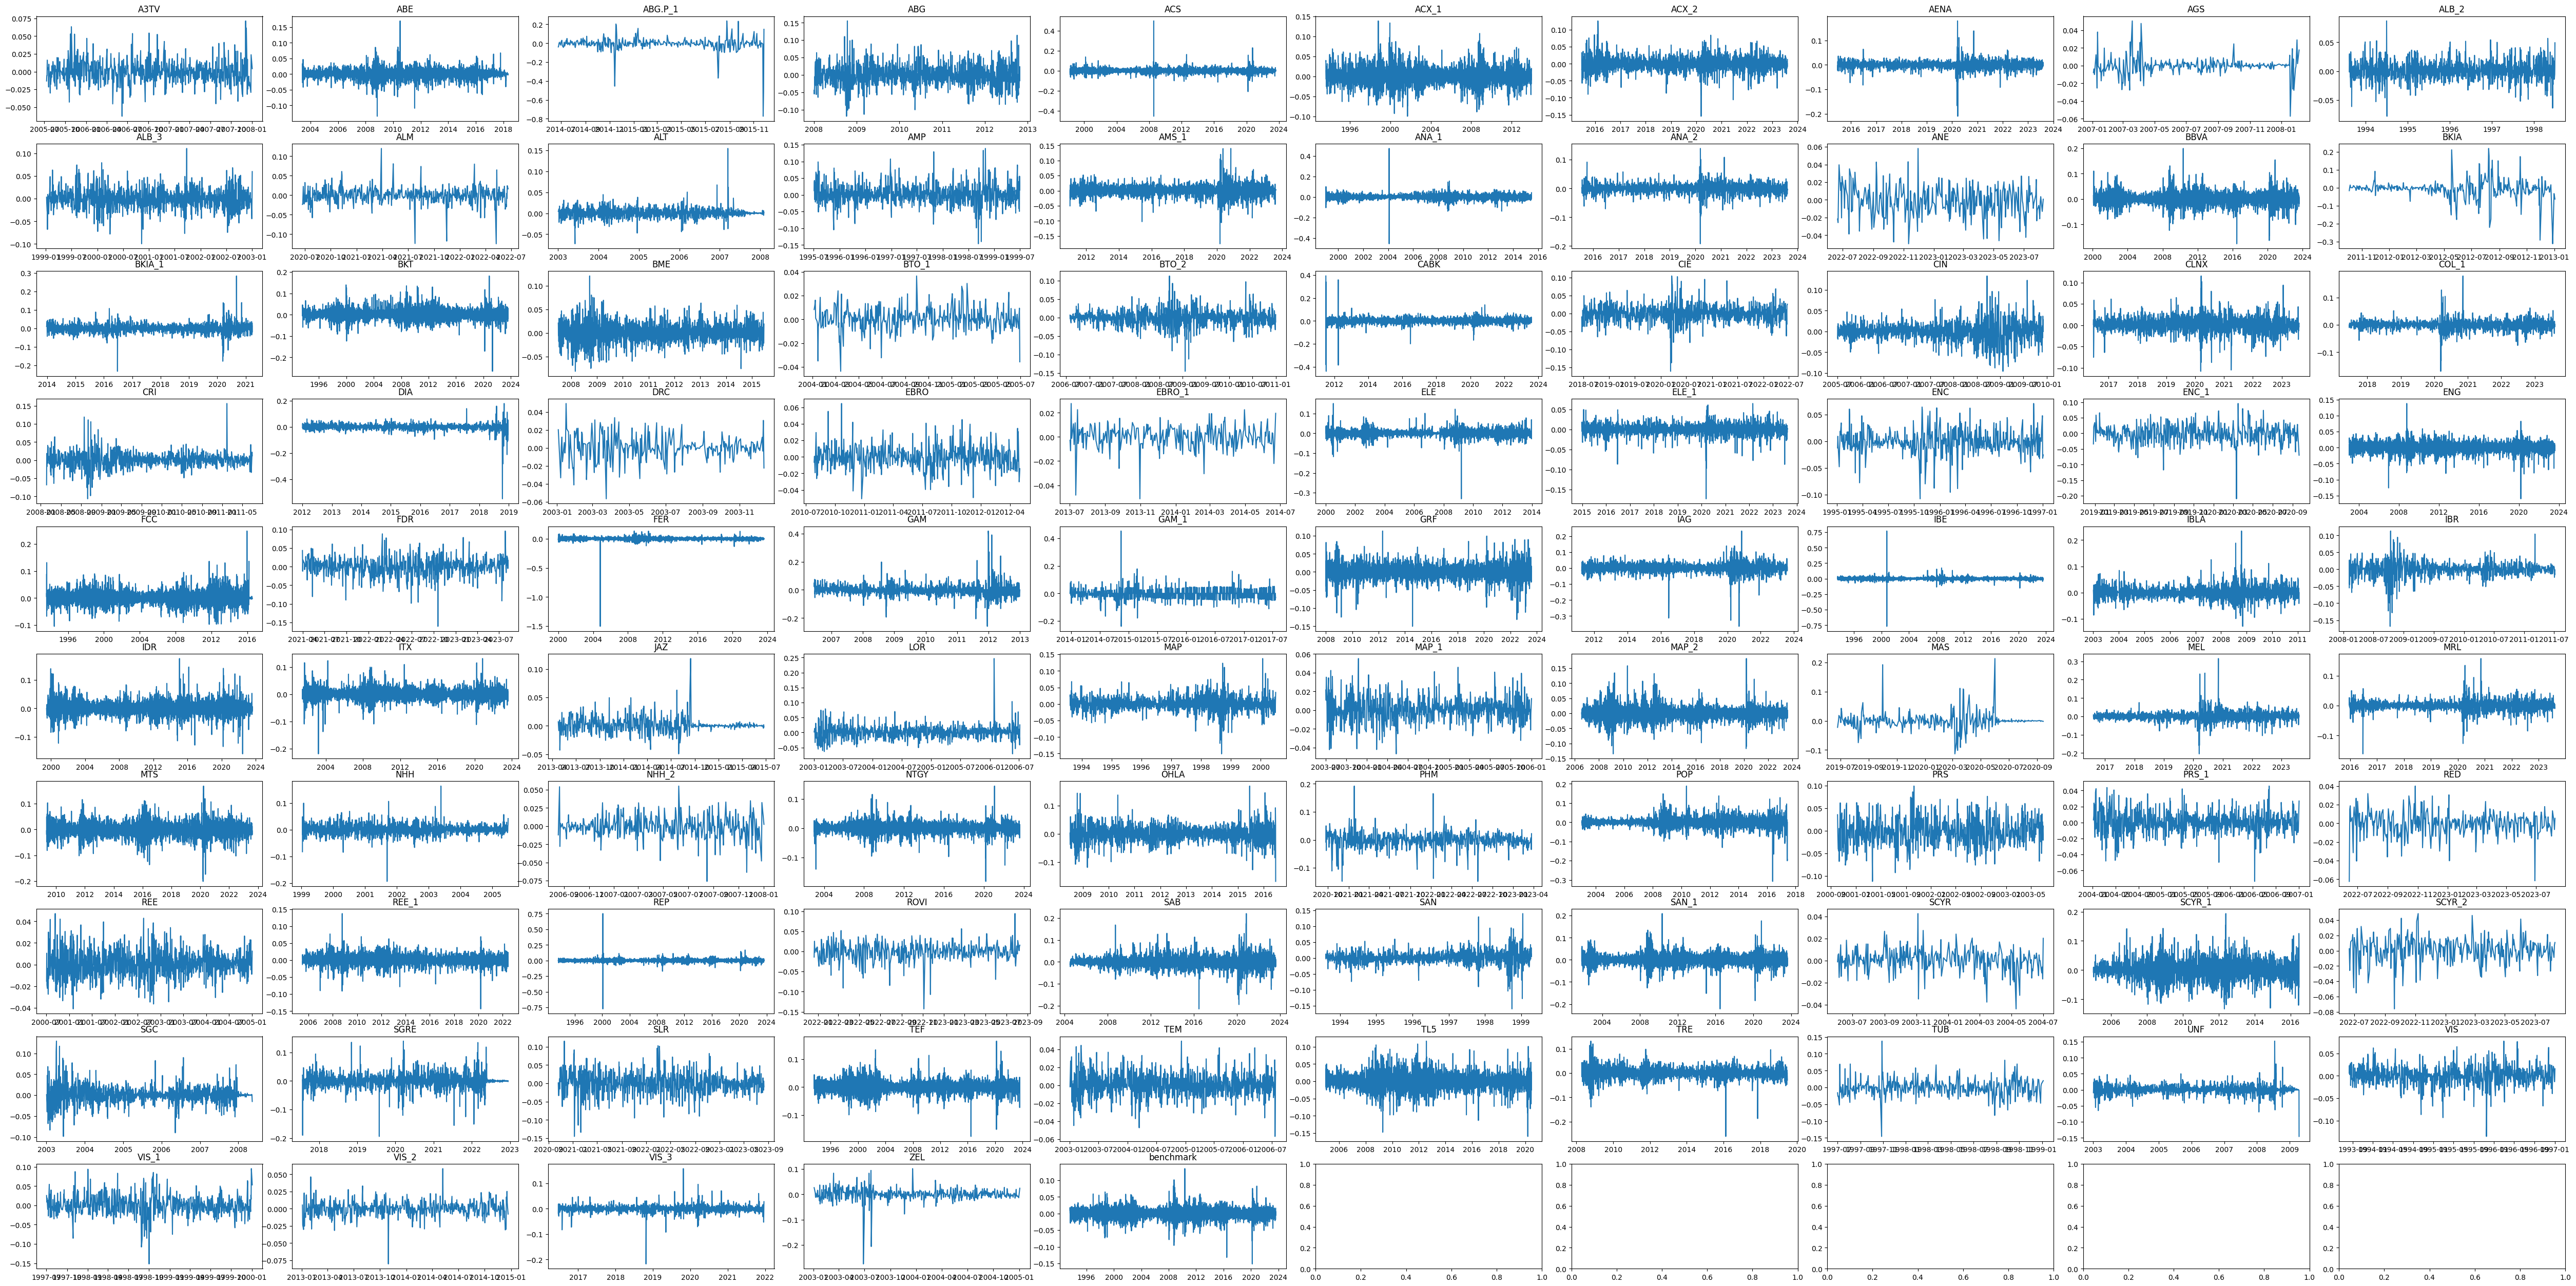

In [715]:
# GRAFICAMOS LOS RETORNOS DE TODOS LOS ACTIVOS
fig, axs = plt.subplots(nrows=10,ncols=10, figsize=(50, 25))
fig.tight_layout()
axs = axs.ravel()

for i in range(len(returns.columns)):
    axs[i].plot(returns[returns.columns[i]].dropna())
    axs[i].set_title(returns.columns[i])

In [ ]:
plt.hist(returns[])